예측 속도를 높이고, 트랜스포머 모델의 메모리 사용량 줄이는 네 가지 기술  
: 지식 정제 / 양자화 / 가지치기 / 그래프 최적화(ONNX 포맷과 ONNX 런타임 사용)

### 의도 탐지 예제

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/8.18k [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--transformersbook--bert-base-uncased-finetuned-clinc. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [4]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query) # 예측한 의도와 신뢰도 점수

[{'label': 'car_rental', 'score': 0.5490036010742188}]

### 벤치마크 클래스 만들기

In [5]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus") # plus : 범위 밖의 훈련 샘플이 담긴 서브셋

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [6]:
sample = clinc["test"][42]
sample # 의도는 ID로 제공

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [7]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"]) # 의도 : ID를 문자열로 쉽게 매핑

'transfer'

In [8]:
import evaluate

accuracy_score = evaluate.load("accuracy")

In [14]:
import torch
import numpy as np
from pathlib import Path
from time import perf_counter


class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset :
            pred = self.pipeline(example['text'])[0]['label']
            label = example['intent']
            preds.append(intents.str2int(pred))
            labels.append(label)
        accuracy = accuracy_score.compute(predictions = preds, references = labels)
        print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
        return accuracy

    
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        # state_dict() : 모델의 층과 학습가능한 파라미터(가중치와 편향)를 매핑하는 dict 반환
        # 키 : BERT 층 / 값 : BERT 텐서 
        tmp_path = Path('model.pt')
        torch.save(state_dict, tmp_path)
        # 메가바이트 단위로 크기 계산
        size_mb = Path(tmp_path).stat().st_size / (1024*1024)
        # 임시 파일 삭제
        tmp_path.unlink()
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}
        

    def time_pipeline(self, query="What is the pin number for my account?"):  # 쿼리마다 평균적인 레이턴시 잼
        latencies = []
        # 워밍업
        for _ in range(10) :
            _ = self.pipeline(query)
        # 실행 측정
        for _ in range(100) :
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # 통계 계산
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}


    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [15]:
# 기준 모델
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.15
평균 레이턴시 (ms) - 47.53 +\- 5.07
테스트 세트 정확도 - 0.867


### 지식 정제로 모델 크기 줄이기
* 지식 정제 트레이너 만들기

In [16]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha  # 정제 손실의 상대적인 가중치 제어
        self.temperature = temperature # 레이블의 확률 분포를 얼마나 완만하게 만들지 조절

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

In [18]:
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        
        # 스튜던트의 크로스 엔트로피 손실과 로짓 추출
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        
        # 티처의 로짓 추출
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
            
        # 확률을 부드럽게하고 정제 손실 계산
        loss_fct = nn.KLDivLoss(reduction="batchmean") # KL 발산
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        
        # 가중 평균된 스튜던트 손실 반환
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

* 좋은 스튜던트 초기화 선택하기
    * 레이턴시와 메모리 사용량을 줄이기 위해 스튜던트로 작은 모델 골라야
    * 경험 법칙에 의하면 티처와 스튜던트가 동일한 종류의 모델일 때 지식 정제 잘 동작함 -- BERT와 RoBERTa처럼 모델 종류가 다를 때 출력 임베딩 공간이 달라 스튜던트가 티처를 모방하는 데 방해가 됨

In [19]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [20]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [46]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir='C:/Users/knuyh/Desktop', evaluation_strategy = "epoch",
    num_train_epochs=3, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True)
# 처음에는 alpha를 1로 지정해 티처로부터 어떤 신호도 받지 않고 성능 확인

In [47]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = 'error'

In [48]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [49]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [50]:
from transformers import AutoModelForSequenceClassification

def student_init():
    return AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config)

In [51]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_ckpt, num_labels=num_labels)

In [52]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,4.356300,3.448467,0.703226
2,2.950100,2.370932,0.820645
3,2.250700,2.044150,0.840000


TrainOutput(global_step=954, training_loss=3.182282893662683, metrics={'train_runtime': 7058.5071, 'train_samples_per_second': 6.482, 'train_steps_per_second': 0.135, 'total_flos': 249062300327400.0, 'train_loss': 3.182282893662683, 'epoch': 3.0})

In [53]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--transformersbook--distilbert-base-uncased-finetuned-clinc. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [54]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 70.97 +\- 31.32
테스트 세트 정확도 - 0.858


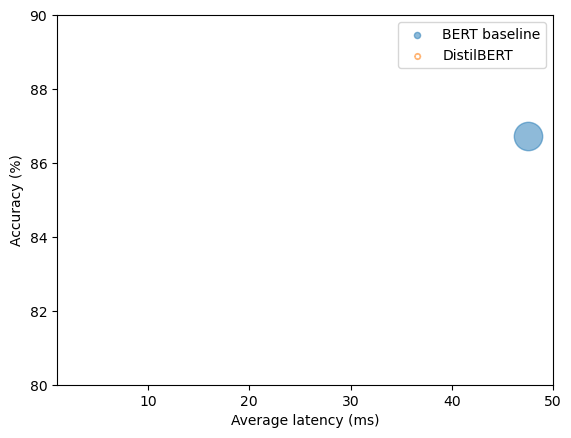

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위 지정
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

작은 모델을 사용해 평균 레이턴시를 크게 줄였음  
티처의 정제 손실 추가해보기

* 옵투나로 좋은 하이퍼파라미터 찾기

In [56]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2) # 균등하게 샘플링할 파라미터 범위 지정
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [59]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-08-02 11:27:20,820] A new study created in memory with name: no-name-e64f6afa-e5b5-4619-879c-51fe58dc6d00
[I 2024-08-02 11:27:20,839] Trial 0 finished with value: 197.40361824165817 and parameters: {'x': -0.38303787554184554, 'y': 1.5448983475204279}. Best is trial 0 with value: 197.40361824165817.
[I 2024-08-02 11:27:20,844] Trial 1 finished with value: 538.9884567126995 and parameters: {'x': 1.6291780467216683, 'y': 0.3334613364264021}. Best is trial 0 with value: 197.40361824165817.
[I 2024-08-02 11:27:20,848] Trial 2 finished with value: 5.872215096507523 and parameters: {'x': -1.1155689585303339, 'y': 1.1263169850840278}. Best is trial 2 with value: 5.872215096507523.
[I 2024-08-02 11:27:20,854] Trial 3 finished with value: 118.70205319118675 and parameters: {'x': 0.8714482218583242, 'y': -0.33000687282769325}. Best is trial 2 with value: 5.872215096507523.
[I 2024-08-02 11:27:20,860] Trial 4 finished with value: 332.95066660703066 and parameters: {'x': 0.09263318265107401

[I 2024-08-02 11:27:22,522] Trial 42 finished with value: 1.1661833768853724 and parameters: {'x': 0.288437969967569, 'y': 0.1644284053925825}. Best is trial 41 with value: 0.44960966097618793.
[I 2024-08-02 11:27:22,571] Trial 43 finished with value: 0.34186818194930163 and parameters: {'x': 0.4276457622309091, 'y': 0.17093150112531758}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:27:22,614] Trial 44 finished with value: 181.6854626257205 and parameters: {'x': 0.8315804945004462, 'y': -0.6562761570803636}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:27:22,655] Trial 45 finished with value: 0.8002350245652193 and parameters: {'x': 0.33373073258246266, 'y': 0.1710687715801777}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:27:22,730] Trial 46 finished with value: 7.361887594265816 and parameters: {'x': 0.3738278487441027, 'y': -0.12425645219045808}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:27:22

[I 2024-08-02 11:27:24,312] Trial 84 finished with value: 0.863897616921725 and parameters: {'x': 0.2955263100887491, 'y': 0.026704583807825824}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:27:24,356] Trial 85 finished with value: 0.5406866827703981 and parameters: {'x': 0.33690004856679656, 'y': 0.08172348400174048}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:27:24,403] Trial 86 finished with value: 12.027790773939955 and parameters: {'x': 0.6387553032020119, 'y': 0.06308380876895417}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:27:24,451] Trial 87 finished with value: 16.681827441562074 and parameters: {'x': 0.47534224915968526, 'y': -0.17909988733210283}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:27:24,492] Trial 88 finished with value: 9.041516458451357 and parameters: {'x': 0.3411987168124785, 'y': 0.40980193085597993}. Best is trial 43 with value: 0.34186818194930163.
[I 2024-08-02 11:2

[I 2024-08-02 11:27:26,000] Trial 126 finished with value: 12.01461796924494 and parameters: {'x': 0.41807920352763916, 'y': 0.516491642073985}. Best is trial 118 with value: 0.32499933231964445.
[I 2024-08-02 11:27:26,034] Trial 127 finished with value: 5.9527596708700115 and parameters: {'x': 0.7179073671473446, 'y': 0.2730444710694012}. Best is trial 118 with value: 0.32499933231964445.
[I 2024-08-02 11:27:26,069] Trial 128 finished with value: 88.73620875626477 and parameters: {'x': 1.1599428793160498, 'y': 0.40360429240580076}. Best is trial 118 with value: 0.32499933231964445.
[I 2024-08-02 11:27:26,106] Trial 129 finished with value: 951.0387734908381 and parameters: {'x': 1.8054149158144197, 'y': 0.17668328789230836}. Best is trial 118 with value: 0.32499933231964445.
[I 2024-08-02 11:27:26,138] Trial 130 finished with value: 1.2292883073757126 and parameters: {'x': 0.11215372661423156, 'y': -0.053830675180975285}. Best is trial 118 with value: 0.32499933231964445.
[I 2024-08-0

[I 2024-08-02 11:27:27,633] Trial 168 finished with value: 2.077611322035337 and parameters: {'x': 0.5061085316175911, 'y': 0.3915593805314851}. Best is trial 163 with value: 0.1351359709817165.
[I 2024-08-02 11:27:27,670] Trial 169 finished with value: 0.3603986052434123 and parameters: {'x': 0.6560487770043868, 'y': 0.4796032661397479}. Best is trial 163 with value: 0.1351359709817165.
[I 2024-08-02 11:27:27,709] Trial 170 finished with value: 0.522955534289103 and parameters: {'x': 0.6436419306866868, 'y': 0.4772006419841247}. Best is trial 163 with value: 0.1351359709817165.
[I 2024-08-02 11:27:27,747] Trial 171 finished with value: 0.2763713378756556 and parameters: {'x': 0.6562979587304988, 'y': 0.4705064330407416}. Best is trial 163 with value: 0.1351359709817165.
[I 2024-08-02 11:27:27,784] Trial 172 finished with value: 0.040648255595129176 and parameters: {'x': 0.8380581871644457, 'y': 0.6903319019107997}. Best is trial 172 with value: 0.040648255595129176.
[I 2024-08-02 11:2

[I 2024-08-02 11:27:29,304] Trial 210 finished with value: 0.6184707143269036 and parameters: {'x': 1.0606471894048048, 'y': 1.2033811737310858}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:29,346] Trial 211 finished with value: 1.0017626785515565 and parameters: {'x': 0.8380823434223119, 'y': 0.8011517137098285}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:29,387] Trial 212 finished with value: 4.374809345346718 and parameters: {'x': 0.6921937650025913, 'y': 0.6860153798580945}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:29,427] Trial 213 finished with value: 0.10506216786758409 and parameters: {'x': 0.9370991130430174, 'y': 0.9099518617312217}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:29,470] Trial 214 finished with value: 0.34634887860944485 and parameters: {'x': 0.9835751879022229, 'y': 0.9085916619066899}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 

[I 2024-08-02 11:27:31,071] Trial 252 finished with value: 44.30302289462106 and parameters: {'x': 0.8433210058172851, 'y': 1.3766110473200355}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:31,115] Trial 253 finished with value: 0.8438728704487234 and parameters: {'x': 0.7307873001524665, 'y': 0.6218793096837648}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:31,158] Trial 254 finished with value: 46.25213964623509 and parameters: {'x': 0.8963231605905841, 'y': 1.4834054343048284}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:31,204] Trial 255 finished with value: 2.9304875952683953 and parameters: {'x': 0.7708291176756392, 'y': 0.7638232861032046}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:31,251] Trial 256 finished with value: 0.06065854193275065 and parameters: {'x': 0.8410676123862237, 'y': 0.7262093607035484}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11

[I 2024-08-02 11:27:33,042] Trial 294 finished with value: 5.443241980500672 and parameters: {'x': 0.9641118638156222, 'y': 0.6962317249121871}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:33,087] Trial 295 finished with value: 0.9999278236756313 and parameters: {'x': 0.8418907632644246, 'y': 0.8075185651042611}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:33,132] Trial 296 finished with value: 104.19804252989431 and parameters: {'x': 0.7603960235320237, 'y': 1.5986952897698987}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:33,179] Trial 297 finished with value: 0.904202697824634 and parameters: {'x': 0.8948401307400331, 'y': 0.8952451609453339}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:33,224] Trial 298 finished with value: 710.6705568387038 and parameters: {'x': 1.7926734913152655, 'y': 0.5490164938683297}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:2

[I 2024-08-02 11:27:35,126] Trial 336 finished with value: 4.041014804303382 and parameters: {'x': 0.7270288797363156, 'y': 0.727731770534228}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:35,173] Trial 337 finished with value: 8.394153048813283 and parameters: {'x': 1.041883975876407, 'y': 0.7958258474230713}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:35,221] Trial 338 finished with value: 0.5410826571359465 and parameters: {'x': 0.9353407777417296, 'y': 0.948135956614521}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:35,272] Trial 339 finished with value: 0.06412650862285621 and parameters: {'x': 0.8140654648913733, 'y': 0.6798941073195783}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:35,319] Trial 340 finished with value: 7.456958568065287 and parameters: {'x': 0.874387908161569, 'y': 1.037339480594995}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:35

[I 2024-08-02 11:27:37,194] Trial 378 finished with value: 1.3654421292058503 and parameters: {'x': 1.0408980263977277, 'y': 0.9666881601438648}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:37,242] Trial 379 finished with value: 31.08619073729096 and parameters: {'x': 0.7474013313674823, 'y': 1.115586170227828}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:37,288] Trial 380 finished with value: 0.02616376871236286 and parameters: {'x': 0.880219571859734, 'y': 0.7639161599399049}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:37,333] Trial 381 finished with value: 0.43777575841550903 and parameters: {'x': 0.9663141047021437, 'y': 0.8676841309428417}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:37,379] Trial 382 finished with value: 0.18631820229084636 and parameters: {'x': 0.9001110347578742, 'y': 0.7682069710978803}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 1

[I 2024-08-02 11:27:39,216] Trial 420 finished with value: 1.2747668957235747 and parameters: {'x': 0.904865505472554, 'y': 0.9312856417508664}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:39,262] Trial 421 finished with value: 4.333652026732853 and parameters: {'x': -0.9227583951381706, 'y': 0.7716925688550703}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:39,314] Trial 422 finished with value: 6.5854823420145 and parameters: {'x': 0.7716074504909542, 'y': 0.8509816410658886}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:39,360] Trial 423 finished with value: 13.75143476531721 and parameters: {'x': 0.9974260827654213, 'y': 0.6240296096865603}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:39,405] Trial 424 finished with value: 7.928240822513774 and parameters: {'x': 0.8643473486041872, 'y': 1.0283407021947444}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:3

[I 2024-08-02 11:27:41,206] Trial 462 finished with value: 7.167373777555892 and parameters: {'x': 0.8197616460052026, 'y': 0.9391212659324568}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:41,255] Trial 463 finished with value: 2.081311197334907 and parameters: {'x': 0.9275308388576886, 'y': 0.716228085879448}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:41,299] Trial 464 finished with value: 24.808120399560405 and parameters: {'x': 0.7353273431508279, 'y': 1.0380800924536204}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:41,348] Trial 465 finished with value: 0.6597311321896954 and parameters: {'x': 0.8579454713975937, 'y': 0.8160424046754367}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:41,399] Trial 466 finished with value: 1.6489002866860718 and parameters: {'x': 1.031726318249738, 'y': 1.1928295088254264}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27

[I 2024-08-02 11:27:43,344] Trial 504 finished with value: 7.014404871883071 and parameters: {'x': 0.8740551514759097, 'y': 1.0285199983797455}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:43,399] Trial 505 finished with value: 0.6938830811233456 and parameters: {'x': 0.9864920164552777, 'y': 0.8898778068903841}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:43,446] Trial 506 finished with value: 4.390535054059085 and parameters: {'x': 0.762341430977731, 'y': 0.7893483534633625}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:43,492] Trial 507 finished with value: 3.6874660325640347 and parameters: {'x': 0.9350421390852226, 'y': 0.6823859416000738}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:43,539] Trial 508 finished with value: 46.57279118593764 and parameters: {'x': 0.6630275501244869, 'y': 1.1212156902613732}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27

[I 2024-08-02 11:27:45,443] Trial 546 finished with value: 45.140852528735415 and parameters: {'x': 0.5770841012414045, 'y': 1.0035631183245406}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:45,490] Trial 547 finished with value: 39.63474002978037 and parameters: {'x': 1.1050763863058548, 'y': 0.5917202380535102}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:45,542] Trial 548 finished with value: 0.8386526776284217 and parameters: {'x': 0.905060743137377, 'y': 0.7280504157710169}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:45,590] Trial 549 finished with value: 3.2845392801189184 and parameters: {'x': 1.0087087472952985, 'y': 0.8362624499374012}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:45,638] Trial 550 finished with value: 8.886195232445603 and parameters: {'x': 0.8038036669843686, 'y': 0.9435512088393376}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:2

[I 2024-08-02 11:27:47,576] Trial 588 finished with value: 32.71632790093182 and parameters: {'x': 0.5885151485861345, 'y': 0.9168499321573105}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:47,626] Trial 589 finished with value: 4.614579502862475 and parameters: {'x': 0.9291326384428764, 'y': 0.6485886633646846}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:47,676] Trial 590 finished with value: 7.318824878392646 and parameters: {'x': 0.8234277901589407, 'y': 0.40807690073149333}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:47,730] Trial 591 finished with value: 0.27683563261132854 and parameters: {'x': 0.9832816155292401, 'y': 1.0194313395485706}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:47,783] Trial 592 finished with value: 7.617976672123619 and parameters: {'x': 1.0605823712403697, 'y': 0.8488946384260467}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:

[I 2024-08-02 11:27:49,891] Trial 630 finished with value: 7.693093835282619 and parameters: {'x': 1.113307645248681, 'y': 0.9623211791968634}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:49,942] Trial 631 finished with value: 496.23607386158443 and parameters: {'x': 0.9165894767227187, 'y': -1.3874837987359623}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:49,993] Trial 632 finished with value: 11.969376090610943 and parameters: {'x': -1.1971178470311852, 'y': 1.165845012358443}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:50,043] Trial 633 finished with value: 3.9564128567581953 and parameters: {'x': 1.017089607595062, 'y': 0.8355712748534819}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:50,096] Trial 634 finished with value: 18.435613640726842 and parameters: {'x': 1.1585302859207804, 'y': 0.9131180500153502}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:

[I 2024-08-02 11:27:52,211] Trial 672 finished with value: 19.694467819394724 and parameters: {'x': 1.121162515433548, 'y': 0.8133863212262888}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:52,270] Trial 673 finished with value: 3.8523856640243612 and parameters: {'x': 0.8631740380193317, 'y': 0.9408668744433996}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:52,330] Trial 674 finished with value: 759.9244899746518 and parameters: {'x': 1.8535313686102368, 'y': 0.6802274239872987}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:52,395] Trial 675 finished with value: 107.57048321453357 and parameters: {'x': -0.040735306675635186, 'y': 1.0335864616463892}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 11:27:52,452] Trial 676 finished with value: 5.906641268740142 and parameters: {'x': 1.0014611865680871, 'y': 0.7598887261933335}. Best is trial 185 with value: 0.00775572126485168.
[I 2024-08-02 1

[I 2024-08-02 11:27:54,625] Trial 714 finished with value: 7.010413770757217 and parameters: {'x': 1.1231083663589227, 'y': 0.9968869001303653}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:54,679] Trial 715 finished with value: 104.55767298984586 and parameters: {'x': 1.3643194822934412, 'y': 0.83948241009972}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:54,730] Trial 716 finished with value: 2.531305988045018 and parameters: {'x': 1.0383155592101978, 'y': 0.919044558755991}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:54,786] Trial 717 finished with value: 12.776038325433579 and parameters: {'x': 0.9278374280371923, 'y': 1.2182452860352608}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:54,843] Trial 718 finished with value: 7.804584463532741 and parameters: {'x': 0.8833246827410658, 'y': 1.0593856101601142}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-

[I 2024-08-02 11:27:57,052] Trial 756 finished with value: 36.4766699652675 and parameters: {'x': 1.1425910576475808, 'y': 0.7017234857718111}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:57,110] Trial 757 finished with value: 202.07697152958974 and parameters: {'x': -1.512094971318433, 'y': 0.8872659140354354}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:57,176] Trial 758 finished with value: 0.023578214704078167 and parameters: {'x': 0.8685591008871139, 'y': 0.7623331135103515}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:57,246] Trial 759 finished with value: 0.4106831706163328 and parameters: {'x': 0.7472827010532932, 'y': 0.6173226177769142}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:57,306] Trial 760 finished with value: 0.07540990625514754 and parameters: {'x': 0.833438225745587, 'y': 0.7164520683539979}. Best is trial 694 with value: 0.0028801463380608173.
[I 20

[I 2024-08-02 11:27:59,507] Trial 798 finished with value: 0.45878087593638023 and parameters: {'x': 0.9564842253264059, 'y': 0.84726863772268}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:59,572] Trial 799 finished with value: 12.685156883204629 and parameters: {'x': 1.0446023003020364, 'y': 0.7350596158943006}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:59,631] Trial 800 finished with value: 49.88805702986139 and parameters: {'x': 0.5410262551453497, 'y': 0.9975313730241422}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:59,692] Trial 801 finished with value: 627.6196701498687 and parameters: {'x': 1.7373123150054575, 'y': 0.5141054407109755}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:27:59,756] Trial 802 finished with value: 0.7879841656299261 and parameters: {'x': 0.9069895249785423, 'y': 0.910909849868695}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-0

[I 2024-08-02 11:28:02,126] Trial 840 finished with value: 4.073847076633985 and parameters: {'x': 0.9802075512457735, 'y': 1.1626348726828357}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:28:02,187] Trial 841 finished with value: 0.047667869301955636 and parameters: {'x': 1.0867133539402902, 'y': 1.200983045051193}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:28:02,251] Trial 842 finished with value: 98.38950641104174 and parameters: {'x': 1.4185789423080357, 'y': 1.0213349442060604}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:28:02,311] Trial 843 finished with value: 0.4114770580112473 and parameters: {'x': 0.9696528679242373, 'y': 1.0043013367960512}. Best is trial 694 with value: 0.0028801463380608173.
[I 2024-08-02 11:28:02,371] Trial 844 finished with value: 6.8715454470407895 and parameters: {'x': 1.1619596028072317, 'y': 1.0885145985266569}. Best is trial 694 with value: 0.0028801463380608173.
[I 202

[I 2024-08-02 11:28:04,772] Trial 882 finished with value: 68.10580185353099 and parameters: {'x': 1.3251439504675553, 'y': 0.9313848594691281}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:04,831] Trial 883 finished with value: 1.8330666338563466 and parameters: {'x': 0.9645898970331487, 'y': 1.0657781469395582}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:04,894] Trial 884 finished with value: 3.2117507502379787 and parameters: {'x': 1.0497701391098126, 'y': 0.922872886958832}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:04,951] Trial 885 finished with value: 9.097801812728305 and parameters: {'x': 0.953362322167131, 'y': 1.210489285113905}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:05,008] Trial 886 finished with value: 6.871284431705384 and parameters: {'x': 1.1254368091167704, 'y': 1.0047769581790658}. Best is trial 866 with value: 0.00037054593630534723.
[I 202

[I 2024-08-02 11:28:07,456] Trial 924 finished with value: 1.6308376413795336 and parameters: {'x': 0.9762645532244328, 'y': 1.0807746720187983}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:07,521] Trial 925 finished with value: 688.1376097778608 and parameters: {'x': 1.8949930362395464, 'y': 0.9692881023196922}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:07,590] Trial 926 finished with value: 2.404412076778092 and parameters: {'x': 1.0333211196732655, 'y': 1.2227783980685862}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:07,656] Trial 927 finished with value: 37.83799636644001 and parameters: {'x': 0.954721045610058, 'y': 1.5266015837753724}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:07,723] Trial 928 finished with value: 20.746346895102544 and parameters: {'x': 1.2552921541729285, 'y': 1.1209928174313268}. Best is trial 866 with value: 0.00037054593630534723.
[I 2

[I 2024-08-02 11:28:10,176] Trial 966 finished with value: 0.007326461979034676 and parameters: {'x': 0.9946262841297684, 'y': 0.9978240355301153}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:10,250] Trial 967 finished with value: 0.24974798130072715 and parameters: {'x': 1.0014764704825814, 'y': 1.0529296945988296}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:10,314] Trial 968 finished with value: 0.08878546598958659 and parameters: {'x': 1.0173118251966098, 'y': 1.0051767924558355}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:10,388] Trial 969 finished with value: 0.029369039483899118 and parameters: {'x': 1.0113958224185757, 'y': 1.0058220433230518}. Best is trial 866 with value: 0.00037054593630534723.
[I 2024-08-02 11:28:10,455] Trial 970 finished with value: 179.5350581331987 and parameters: {'x': 1.0648670376096359, 'y': -0.20594942063600408}. Best is trial 866 with value: 0.000370545936305

In [60]:
study.best_params # 스터디 완료 후 최상의 파라미터 얻음

{'x': 0.9808333529766853, 'y': 0.9622125481926124}

In [63]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [66]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=3, direction="maximize", hp_space=hp_space)
# 최대화된 목적 함수의 값과 하이퍼파라미터 담음

[I 2024-08-03 09:34:58,650] A new study created in memory with name: no-name-9d64c141-a130-4330-9cde-a9bf76b36c57
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.444500,0.236395,0.571935
2,0.200400,0.124032,0.801935
3,0.135000,0.092066,0.849677
4,0.114300,0.083857,0.862258


[I 2024-08-03 12:14:56,233] Trial 0 finished with value: 0.8622580645161291 and parameters: {'num_train_epochs': 4, 'alpha': 0.9395766664659024, 'temperature': 6}. Best is trial 0 with value: 0.8622580645161291.
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.521000,0.308145,0.552258
2,0.288500,0.226661,0.672258


[I 2024-08-03 13:29:15,158] Trial 1 finished with value: 0.672258064516129 and parameters: {'num_train_epochs': 2, 'alpha': 0.9653195428062227, 'temperature': 4}. Best is trial 0 with value: 0.8622580645161291.
C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.387100,0.201618,0.552903
2,0.170100,0.104375,0.805806
3,0.112900,0.075983,0.860000
4,0.091700,0.063875,0.878065
5,0.082600,0.060084,0.882581


[I 2024-08-03 16:47:32,720] Trial 2 finished with value: 0.8825806451612903 and parameters: {'num_train_epochs': 5, 'alpha': 0.6431745650788608, 'temperature': 17}. Best is trial 2 with value: 0.8825806451612903.


In [67]:
print(best_run)

BestRun(run_id='2', objective=0.8825806451612903, hyperparameters={'num_train_epochs': 5, 'alpha': 0.6431745650788608, 'temperature': 17}, run_summary=None)


In [68]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer 생성
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

C:\Users\knuyh\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.937800,2.248736,0.725806
2,1.827200,1.333700,0.850323
3,1.137400,0.882723,0.896774
4,0.800700,0.694789,0.914194
5,0.665100,0.640371,0.920000


스튜던트의 매개변수 개수는 거의 티처의 절반이지만  
티처의 정확도에 버금가는 스튜던트 훈련

* 정제 모델 벤치마크 수행하기

In [72]:
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--transformersbook--distilbert-base-uncased-distilled-clinc. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

모델 크기 (MB) - 255.88
평균 레이턴시 (ms) - 27.70 +\- 2.31
테스트 세트 정확도 - 0.868


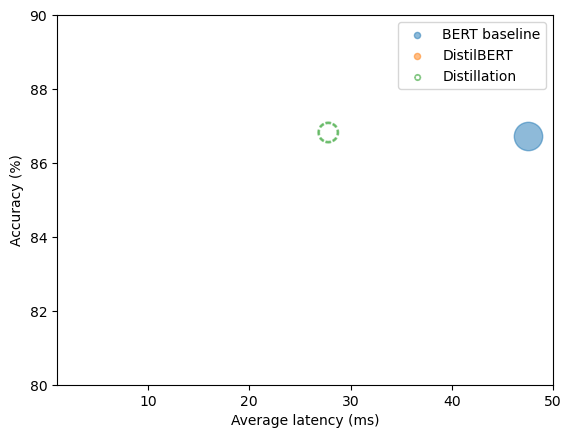

In [73]:
plot_metrics(perf_metrics, optim_type)

모델 크기와 레이턴시는 기본적으로 DistilBERT에 비해 달라지지 않았지만, 정확도는 향상되고 티처의 성능도 뛰어난다.

### 양자화로 모델 속도 높이기
지식 정제를 사용해 티처의 정보를 작은 스튜던트 모델로 전송해 추론 실행 시, 계산 비용과 메모리 사용량 줄이는 방법  

<br>
양자화 방식 : 계산량을 줄이는 대신 가중치와 활성화 출력을 32비트 부동 소수점(FP32)이 아닌 8비트 정수(INT8) 같이 정밀도가 낮은 데이터 타입으로 변환해 계산 효율적으로 수행

* 아핀 변환 : 고정 소수점 숫자를 역양자화해 부동 소수점으로 되돌려야 하는 매핑

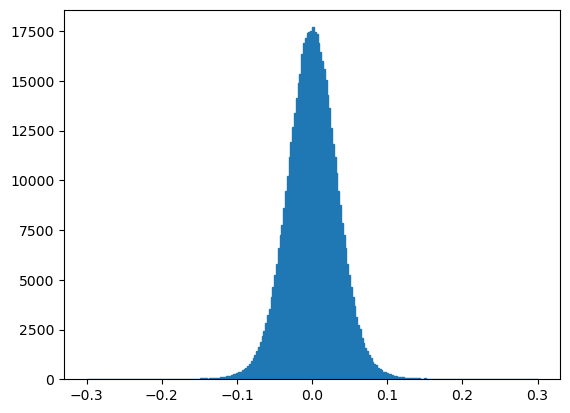

In [74]:
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [75]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [76]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [77]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

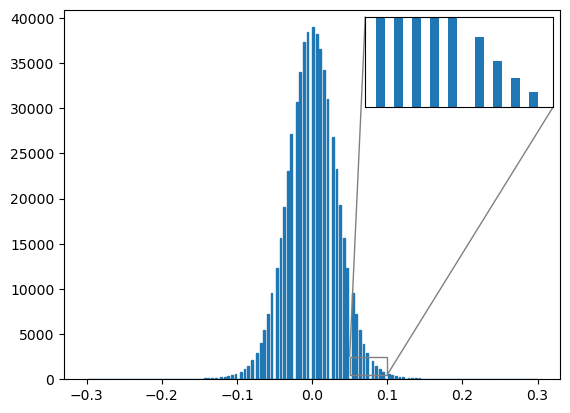

In [78]:
# 트랜스포머 가중치에서 양자화 효과
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# 히스토그램 그리기
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# 확대 그림 만들기
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(),
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [79]:
%%timeit
weights @ weights

3.8 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [80]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [81]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

201 µs ± 3.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [82]:
# 가중치 텐서와 양자화된 텐서 저장크기 비교
import sys

sys.getsizeof(weights.untyped_storage()) / sys.getsizeof(quantized_weights.untyped_storage())

3.999633833760527

보통 선형 층만 양자화한다.  
양자화에서 주의할 점 - 모델에 있는 모든 연산에서 정밀도를 바꾸면 모델의 계산 그래프 각 지점에서 작은 변동 생김
<br>

[심층 신경망에서 사용하는 양자화 방법]
- 동적 양자화
    * 훈련 도중에 아무것도 바뀌지 않고 추론 과정에만 적응
    * 모델 가중치가 추론 전에 INT8로 변환
    * 가중치 외에 모델의 활성화도 양자화되는데, 이 양자화가 즉석에서 일어남
    * 부동 소수점 포맷으로 활성화를 메모리에 쓰고 읽어 정수와 부동 소수점 간의 변환이 성능 병목이 되는 경우도 있음
    
- 정적 양자화
    * 즉석에서 활성화를 양자화하지 않고 양자화 체계를 사전에 계산해 부동 소수점 변환을 피함
    * 추론에 앞서 대표 샘플 데이터에서 활성화 패턴을 관찰해 수행한 후 이상적인 양자화 체계를 계산해 저장
    * 훈련과 추론 과정에서 정밀도 차이로 모델 성능이 떨어짐
    
- 양자화를 고려한 훈련
    * 가짜로 FP32 값을 양자화해 훈련 중에 양자화의 효과 시뮬레이션
    * 훈련할 때 INT8 대신 FP32 반올림해 양자화 효과 흉내냄
    * 정방향 패스와 역방향 패스에서 모두 적용되며 정적 양자화와 동적 양자화 사용해 모델 성능 향상시킴

In [83]:
# 동적 양자화
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


모델 정확도에 미치는 영향 거의 없음 (양자화 특징)

### 양자화된 모델의 벤치마크 수행하기

In [84]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 132.39
평균 레이턴시 (ms) - 52.44 +\- 7.29
테스트 세트 정확도 - 0.876


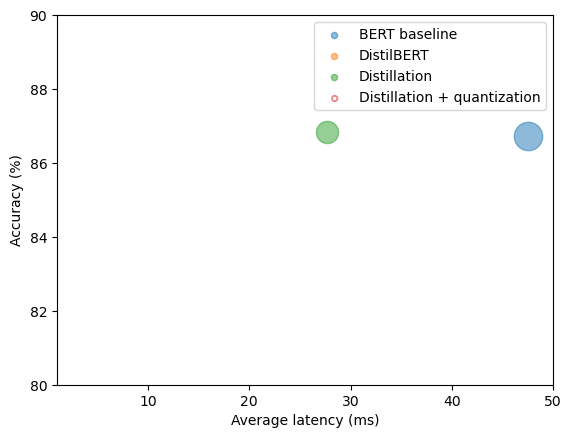

In [85]:
plot_metrics(perf_metrics, optim_type)

양자화된 모델의 크기가 정제된 모델의 거의 절반이고 심지어 성능도 약간 향상됐다.

### ONNX와 ONNX 런타임으로 추론 최적화하기
* ONNX는 변경 불가능한 연산 규격을 그룹화하기 위해 연산자 집합 사용

In [86]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE" # 대기 스레드 활성 상태로 지정(CPU프로세서 사이클 사용)

In [105]:
import onnx
from transformers.convert_graph_to_onnx import convert

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = "onnx/model.onnx"
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=Path(onnx_model_path), opset=12, pipeline_name="text-classification")

ONNX opset version set to: 12
Loading pipeline (model: transformersbook/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='transformersbook/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=

AttributeError: module 'onnx' has no attribute 'load_model_from_string'

In [111]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [ ]:
onnx_model = create_model_for_provider(onnx_model_path)

In [ ]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape  # (1, 151)

In [ ]:
np.argmax(logits_onnx) # 예측  61

In [ ]:
clinc_enc["test"][0]["labels"] # 정답  61

In [113]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [ ]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)
# [{'label': 'car_rental', 'score': 0.57666945}]

In [114]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [ ]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

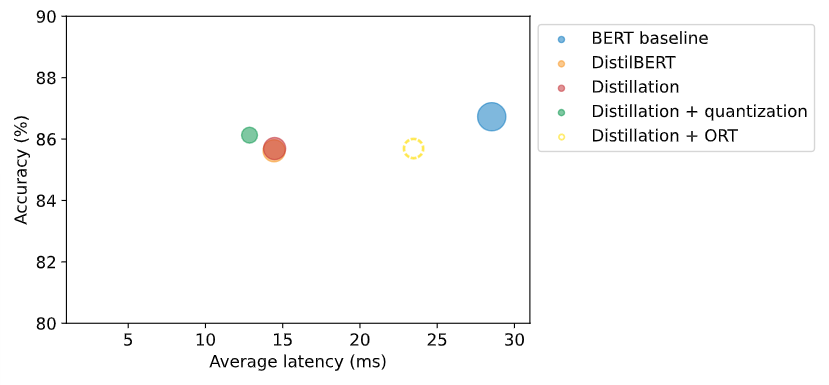

레이턴시 향상됨

ORT모델을 양자화하기 위해 세 가지 방법 제공  
이 중 정제 모델에 동적 양자화 적용

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [ ]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

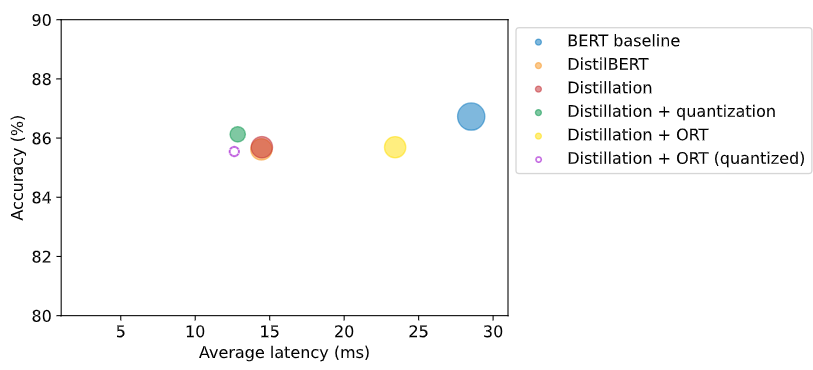

ORT 양자화는 일반 양자화로 얻은 모델(Distillation+quantization)에 비해 모델 크기와 레이턴시 30% 가량 줄임  
ONNX는 임베딩 층도 양자화하기 때문

### 가중치 가지치기로 희소한 모델 만들기
양자화 같은 방법은 표현 정밀도를 낮춰 모델 크기를 줄인다.  
* 가중치 가지치기 : 일부 가중치를 제거해 크기를 줄이는 전략
    * 절댓값 가지치기 : 가중치 절댓값 크기에 따라 점수 계산
        * 계산량이 많다.
        * 두 개의 가중치 클러스터 만듦
        * 각 가중치의 중요도가 현재 작업과 직접적으로 관련된 순수한 지도 학습을 위해 고안됐다는 문제
        * 미세 튜닝 작업에서 중요한 가중치 삭제될 가능성
    * 이동 가지치기 : 미세 튜닝하는 동안 점진적으로 가중치 제거해 모델을 점차 희소하게 만듦
        * 미세 튜닝동안 가중치와 점수 모두 학습됨
        * 완만한 분포 만듦

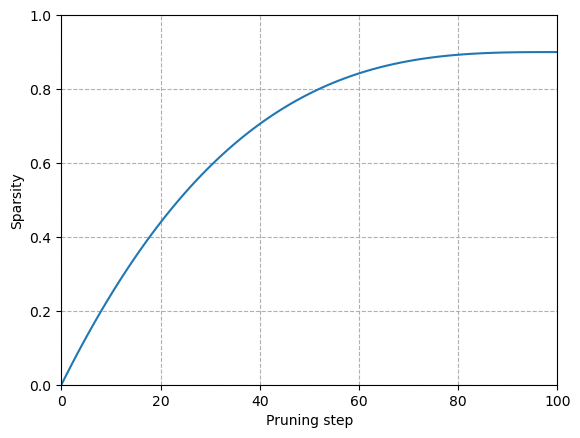

In [115]:
# 절댓값 가지치기에 사용되는 세제곱 희소성 스케줄러
def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()